## <center>**Дипломный проект**

#### <center>**Модель прогнозирования стоимости жилья для агентства недвижимости**

>Автор: Репкин Денис

>Специализация: Data Scientist

>Группа: DST-128 

<center> <img src=https://catherineasquithgallery.com/uploads/posts/2021-02/1613586625_80-p-foni-dlya-finansovikh-prezentatsii-105.jpg width="800"/> </center>


### **Цель проекта**
Разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок, за счет внедрения алгоритма быстрого определения цены на недвижимость по его характеристикам.


In [2]:
#импорт библиотек
import numpy as np
import pandas as pd

import sweetviz as sv

import seaborn as sns
import matplotlib.pyplot as plt

import category_encoders as ce 
import re

from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import pickle
from flask import Flask, request, jsonify
import requests

In [61]:
#создаем файл окружения для воспроизводимости кода
#!pip freeze > requirements.txt

In [3]:
#прочитаем данные
data = pd.read_csv('data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


**Описание признаков:**

➔ 'status' — статус продажи;

➔ 'private pool' и 'PrivatePool' — наличие собственного бассейна;

➔ 'propertyType' — тип объекта недвижимости;

➔ 'street' — адрес объекта;

➔ 'baths' — количество ванных комнат;

➔ 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);

➔ 'fireplace' — наличие камина;

➔ 'city' — город;

➔ 'schools' — сведения о школах в районе;

➔ 'sqft' — площадь в футах;

➔ 'zipcode' — почтовый индекс;

➔ 'beds' — количество спален;

➔ 'state' — штат;

➔ 'stories' — количество этажей;

➔ 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);

➔ **'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).**


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [28]:
#проведем первичное исследование "сырых" данных c помощью библиотеки автоматического анализа Sweetviz:
report = sv.analyze(data)
report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
ERROR: comet_ml is installed, but not configured properly (e.g. check API key setup). HTML reports will not be uploaded.


Согласно экспресс-отчету:
- в данных содержится 50 дублированных строк;
- из 18 признаков: 3 категориальных, 15 - текстовых, числовых признаков не содержится; 
- признаки "mls-id", "private pool" и "PrivatePool" имеют более чем 90% пропущенных значений;

**Вывод:** "сырые" данные не позволяют получить значимое количество информации, поэтому продолжим наши исследования.


### **Очистка и подготовка данных**

In [5]:
#удалим дублирующиеся строки
display(data.shape)
data.drop_duplicates(inplace=True)
display(data.shape)

(377185, 18)

(377135, 18)

In [6]:
#удалим строки с пропущенными значениями в целевом признаке target
display(data.shape)
data.dropna(subset = ['target'], inplace=True)
display(data.shape)

(377135, 18)

(374655, 18)

In [7]:
#вычислим средний по столбцам результат метода isnull() и посмотрим долю пропусков в каждом столбце
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

private pool    98.892047
mls-id          93.344010
PrivatePool     89.291481
fireplace       72.636426
stories         39.970907
baths           28.118402
beds            24.270062
MlsId           17.207297
sqft            10.701846
status          10.477906
propertyType     9.222885
city             0.009075
street           0.000534
dtype: float64

In [8]:
#удаляем признаки с количеством пропусков более 40%, а также малоинформативный признаки MlsId и zipcode
data = data.drop(['private pool', 'mls-id', 'PrivatePool', 'fireplace', 'MlsId', 'zipcode'], axis=1)

data.info()
data.head(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 374655 entries, 0 to 377184
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        335399 non-null  object
 1   propertyType  340101 non-null  object
 2   street        374653 non-null  object
 3   baths         269308 non-null  object
 4   homeFacts     374655 non-null  object
 5   city          374621 non-null  object
 6   schools       374655 non-null  object
 7   sqft          334560 non-null  object
 8   beds          283726 non-null  object
 9   state         374655 non-null  object
 10  stories       224902 non-null  object
 11  target        374655 non-null  object
dtypes: object(12)
memory usage: 37.2+ MB


,status,propertyType,street,baths,homeFacts,city,schools,sqft,beds,state,stories,target
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,4,NC,NaN,"$418,000"
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",3 Beds,WA,2.0,"$310,000"
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",3 Beds,CA,1.0,"$2,895,000"
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",5 Beds,TX,3.0,"$2,395,000"
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,NaN,FL,NaN,"$5,000"


**Работа с признаком target**

In [9]:
data.target.value_counts()

$225,000     1462
$275,000     1355
$250,000     1312
$350,000     1296
$299,900     1276
             ... 
274,359         1
$273,490+       1
$645,000+       1
$28,272         1
$171,306        1
Name: target, Length: 43939, dtype: int64

In [10]:
data[data.target.str.contains('mo', na=False)]['target'].value_counts()

$2,200/mo    11
$1,100/mo    11
$3,500/mo    10
$2,000/mo    10
$1,200/mo    10
             ..
$3,950/mo     1
$3,050/mo     1
$3,450/mo     1
$1,799/mo     1
$890/mo       1
Name: target, Length: 150, dtype: int64

In [11]:
data[data.target.str.contains('-', na=False)]['target'].value_counts()

$1,215 - $1,437/mo    1
Name: target, dtype: int64

In [12]:
np.mean([1.437, 1.215])

1.326

In [13]:
data.loc[data.target=='$1,215 - $1,437/mo', 'target'] = '1,326'

In [14]:
target_dict = {'^\$':'',\
                '\+':'',\
                '\/mo$':'',\
                '\,+':''

    }
data.target = data.target.replace(target_dict, regex=True)

#преобразуем столбец target в числовой тип
data.target = pd.to_numeric(data.target)

In [15]:
#проверим на выбросы для этого воспользуемся функциями:

def tukey_outlier(data, col, log_scale=False, m=1):
    """
    Performs Tukey's outlier detection on a specified column of a dataframe.

    Args:
        data (DataFrame): The input dataframe.
        col (str): The column where outliers need to be detected.
        m (int): Number to add before log rescaling

    Returns:
        DataFrame: Outliers that fall outside the outlier borders, 25, 75 percentile, IQR and outlier borders
    """
    if log_scale:
        x = np.log(data[col]+m)
        print('Outliers are detected in log scale')
    else:
        x = data[col]
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3-Q1
    lb = Q1 - 1.5*IQR
    hb = Q3 + 1.5*IQR
    print(
        '25 percentile: {},'.format(Q1),
        '75 percentile: {},'.format(Q3),
        "IQR: {}, ".format(IQR),
        "Outlier borders: [{lb}, {hb}].".format(lb=lb, hb=hb))
    outliers = data[(x < lb) | (x > hb)]
    return outliers


def outliers_z_score(data, feature, log_scale=False, m=1):
    """
    Performs z-score outlier detection on a specified column of a dataframe.

    Args:
        data (DataFrame): The input dataframe.
        feature (str): The column where outliers need to be detected.
        log_scale (bool): If True, search for outliers in log scale.
        m (int): Number to add before log rescaling

    Returns:
        DataFrame: Outliers that fall outside the lower and upper outlier bounds, lower & upper outlier bound
    """
    if log_scale:
        x = np.log(data[feature]+m)
        print('Outliers are detected in log scale')
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    print (f'z score lower bound {lower_bound}')
    print(f'z score upper bound {upper_bound}')
    return outliers


def distribution(data, col, n=20, m=1):
    """
    Plots the histogram and boxplot of a specified column in a dataframe.

    Args:
        data (DataFrame): The input dataframe.
        col (str): The column to plot.
        n (int): Number of bins in the histogram.
        m (int): Number to add before log rescaling
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

    # Plot histogram with normal values
    histplot1 = sns.histplot(data=data, x=col, bins=n, ax=axes[0, 0])
    histplot1.set_title(f'{col} distribution')

    # Plot histogram with log-transformed values
    histplot2 = sns.histplot(data=data, x=np.log(data[col]+m), bins=n, ax=axes[1, 0])
    histplot2.set_title(f'log scale {col} distribution')

    # Plot boxplot with normal values
    boxplot1 = sns.boxplot(data=data, x=col, ax=axes[0, 1])
    boxplot1.set_title(f'{col} boxplot')

    # Plot boxplot with log-transformed values
    boxplot2 = sns.boxplot(data=data, x=np.log(data[col]+m), ax=axes[1, 1])
    boxplot2.set_title(f'log scale {col} boxplot')

    # Fix layout
    plt.tight_layout()

    # Show the plots
    plt.show()

def outlier_analysis(data, column, m=1, n=100):
    """
    Perform an outlier analysis in a specified column in a dataframe.

    Args:
        data (DataFrame): The input dataframe.
        column (str): The column where outliers need to be detected.
        n (int): Number of bins in the histogram.
        m (int): Number to add before log rescaling
    """
    outl_tukey = tukey_outlier(data, column, log_scale=False, m=m)
    print(f'Number of Tukey outliers in {column} column - {outl_tukey.shape[0]}')
    print('')

    outl_tukey_log = tukey_outlier(data, column, log_scale=True, m=m)
    print(f'Number of Tukey outliers in log {column} column - {outl_tukey_log.shape[0]}')
    print('')

    outl_z = outliers_z_score(data, column, log_scale=False, m=m)
    print(f'Number of z score outliers in {column} column - {outl_z.shape[0]}')
    print('')

    outl_z_log = outliers_z_score(data, column, log_scale=True, m=m)
    print(f'Number of z score outliers in log {column} column - {outl_z_log.shape[0]}')
    print('')

    distribution(data, column, n=n, m=m)

    return {
        'outliers_tukey': outl_tukey,
        'outliers_tukey_log': outl_tukey_log,
        'outliers_z': outl_z,
        'outliers_z_log': outl_z_log
    }

25 percentile: 186990.0, 75 percentile: 582000.0, IQR: 395010.0,  Outlier borders: [-405525.0, 1174515.0].
Number of Tukey outliers in target column - 38413

Outliers are detected in log scale
25 percentile: 12.138815766336272, 75 percentile: 13.274227444925158, IQR: 1.135411678588886,  Outlier borders: [10.435698248452944, 14.977344962808488].
Number of Tukey outliers in log target column - 26747

z score lower bound -4879432.139571512
z score upper bound 6168886.471044468
Number of z score outliers in target column - 3627

Outliers are detected in log scale
z score lower bound 9.021204860974613
z score upper bound 16.25987747976213
Number of z score outliers in log target column - 6232



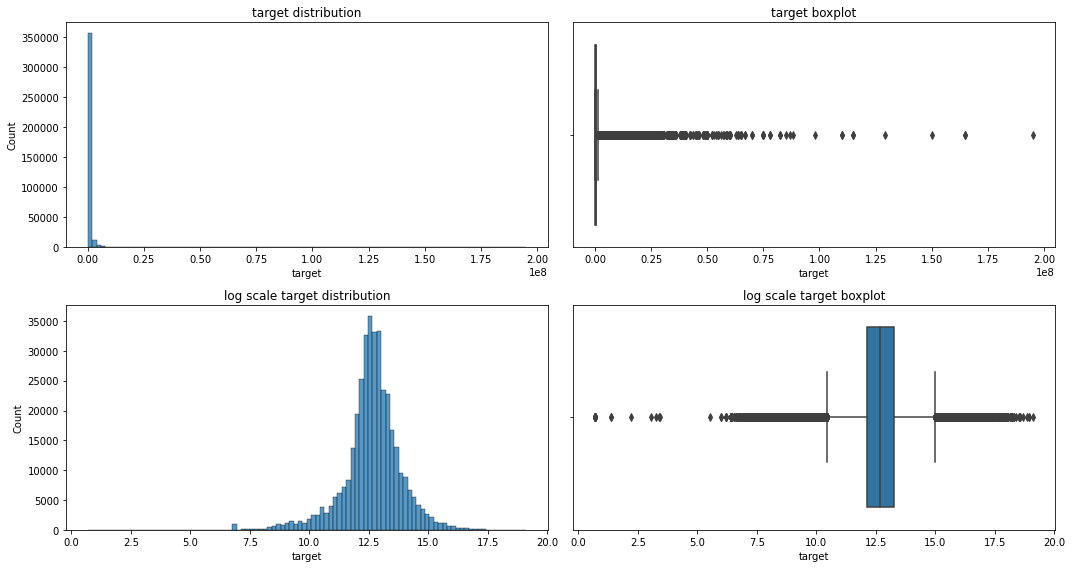

In [16]:
col = 'target'
outliers = outlier_analysis(data, col, m=1, n=100)

In [17]:
#удалим выбросы
data.drop(data.loc[np.log(data.target)<5].index, inplace=True)

data.drop(data.loc[np.log(data.target)>17.5].index, inplace=True)

**Работа с признаком status**

...

**Работа с признаком propertyType**

...

##### <span style="color:red"> *К сожалению, датасет оказался очень сложным для меня. Все мои усилия по преведению данных в вид, пригодный для последующего моделирования, не увенчались успехом. Ниже я привожу работу моделей регрессии, которые применял бы в случае если этап очистки данных был бы успешен. В качестве проверочного использовался учебный датасет из библиотеки sklearn datasets* </span>  

### **Построение моделей прогнозирования**

In [ ]:
#отделение целевого признака от факторов
X = data.drop(['target'], axis=1)
y = data['target']

In [ ]:
#разделение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
#импортируем учебный датасет для проверки работы моделей
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target

In [3]:
#разделение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#нормализуем обучающую и тестовую выборки с помощью MinMaxScaler из библиотеки sklearn
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Линейная регрессия

In [5]:
#модель
lr = LinearRegression()

#обучение
lr.fit(X_train_scaled, y_train)
#предсказание
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

#расчёт показателей производительности модели RMSE и R2 (коэффициент детерминации)
lr_train_rmse = round(mean_squared_error(y_train, y_train_pred)**.5, 2)
lr_train_r2 = r2_score(y_train, y_train_pred)
lr_test_rmse = round(mean_squared_error(y_test, y_test_pred)**.5, 2)
lr_test_r2 = r2_score(y_test, y_test_pred)

#отображение результатов
lr_results = pd.DataFrame(['Linear regression',lr_train_rmse, lr_train_r2, lr_test_rmse, lr_test_r2]).transpose()
lr_results.columns = ['Method','Training RMSE', 'Training R2','Test RMSE', 'Test R2']
lr_results

,Method,Training RMSE,Training R2,Test RMSE,Test R2
0,Linear regression,0.22,0.92542,0.19,0.946896


#### Полиномиальна регрессия

In [6]:
#создание генератора полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)

#обучение
poly.fit(X_train_scaled)
#генерируем полиномиальные признаки
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

#модель
lr_model_poly = LinearRegression()

#обучение
lr_model_poly.fit(X_train_scaled_poly, y_train)
#предсказание
y_train_predict_poly = lr_model_poly.predict(X_train_scaled_poly)
y_test_predict_poly = lr_model_poly.predict(X_test_scaled_poly)

#расчёт показателей производительности модели RMSE и R2 (коэффициент детерминации)
lr_poly_train_rmse = round(mean_squared_error(y_train, y_train_predict_poly)**.5, 2)
lr_poly_train_r2 = r2_score(y_train, y_train_predict_poly)
lr_poly_test_rmse = round(mean_squared_error(y_test, y_test_predict_poly)**.5, 2)
lr_poly_test_r2 = r2_score(y_test, y_test_predict_poly)

#отображение результатов
lr_poly_results = pd.DataFrame(['Polynomial regression', lr_poly_train_rmse, lr_poly_train_r2, lr_poly_test_rmse, lr_poly_test_r2]).transpose()
lr_poly_results.columns = ['Method','Training RMSE', 'Training R2','Test RMSE', 'Test R2']
lr_poly_results

,Method,Training RMSE,Training R2,Test RMSE,Test R2
0,Polynomial regression,0.18,0.952121,0.23,0.927563


#### Полиномиальная регрессия с L2-регуляризацией

In [7]:
#cоздаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = Ridge(alpha=1.0)

#обучение
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#предсказание
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

#расчёт показателей производительности модели RMSE и R2 (коэффициент детерминации)
ridge_lr_poly_train_rmse = round(mean_squared_error(y_train, y_train_predict_poly)**.5, 2)
ridge_lr_poly_train_r2 = r2_score(y_train, y_train_predict_poly)
ridge_lr_poly_test_rmse = round(mean_squared_error(y_test, y_test_predict_poly)**.5, 2)
ridge_lr_poly_test_r2 = r2_score(y_test, y_test_predict_poly)

#отображение результатов
ridge_lr_poly_results = pd.DataFrame(['Polynomial regression with L2', ridge_lr_poly_train_rmse, ridge_lr_poly_train_r2, ridge_lr_poly_test_rmse, ridge_lr_poly_test_r2]).transpose()
ridge_lr_poly_results.columns = ['Method','Training RMSE', 'Training R2','Test RMSE', 'Test R2']
ridge_lr_poly_results

,Method,Training RMSE,Training R2,Test RMSE,Test R2
0,Polynomial regression with L2,0.2,0.93628,0.21,0.937714


#### Дерево решений

In [8]:
#подберем оптимальные гиперпараметры max_depth и min_samples_leaf для алгоритма DecisionTreeRegressor
param_grid_dtr = [
              {'max_depth': [5, 8, 10],
               'min_samples_leaf': [7, 8, 9]}
]

In [11]:
#используем метод поиска по сетке GridSearchCV с кросс-валидацией
grid_search_dtr = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42, #генератор случайных чисел
    ), 
    param_grid=param_grid_dtr, 
    cv=5, 
    n_jobs = -1
)

In [12]:
#поиск наилучших параметров
grid_search_dtr.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_depth': [5, 8, 10],
                          'min_samples_leaf': [7, 8, 9]}])

In [13]:
#наилучшие значения гиперпараметров
print("Наилучшие значения параметров:\n{}".format(grid_search_dtr.best_params_))

Наилучшие значения параметров:
{'max_depth': 5, 'min_samples_leaf': 7}


In [14]:
#итоговая модель хранится в параметре best_estimator_, ей можно воспользоваться для получения прогнозов на новых данных:
print("Наилучшая модель:\n{}".format(grid_search_dtr.best_estimator_))

Наилучшая модель:
DecisionTreeRegressor(max_depth=5, min_samples_leaf=7, random_state=42)


In [15]:
#модель
dtr = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 7, random_state = 42)

#обучение  
dtr.fit(X_train_scaled, y_train)
#предсказание
y_train_pred_dtr = dtr.predict(X_train_scaled)
y_test_pred_dtr = dtr.predict(X_test_scaled)

#расчёт показателей производительности модели RMSE и R2 (коэффициент детерминации)
dtr_train_rmse = round(mean_squared_error(y_train, y_train_pred_dtr)**.5, 2)
dtr_train_r2 = r2_score(y_train, y_train_pred_dtr)
dtr_test_rmse = round(mean_squared_error(y_test, y_test_pred_dtr)**.5, 2)
dtr_test_r2 = r2_score(y_test, y_test_pred_dtr)

#отображение результатов
dtr_results = pd.DataFrame(['DecisionTreeRegressor', dtr_train_rmse, dtr_train_r2, dtr_test_rmse, dtr_test_r2]).transpose()
dtr_results.columns = ['Method','Training RMSE', 'Training R2','Test RMSE', 'Test R2']
dtr_results

,Method,Training RMSE,Training R2,Test RMSE,Test R2
0,DecisionTreeRegressor,0.18,0.952979,0.09,0.987103


#### Случайный лес

In [16]:
#подберем оптимальные гиперпараметры для алгоритма RandomForestRegressor
param_grid_rf = [
              {'max_depth': [4, 7, 10],
               'min_samples_leaf': [4, 6, 8],
               'n_estimators': [100, 200, 300]} 
]

In [18]:
#используем метод поиска по сетке GridSearchCV с кросс-валидацией
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42, #генератор случайных чисел
    ), 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs = -1
)

In [19]:
#поиск наилучших параметров
grid_search_rf.fit(X_train_scaled, y_train) 

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_depth': [4, 7, 10],
                          'min_samples_leaf': [4, 6, 8],
                          'n_estimators': [100, 200, 300]}])

In [20]:
#наилучшие значения гиперпараметров
print("Наилучшие значения параметров:\n{}".format(grid_search_rf.best_params_))

Наилучшие значения параметров:
{'max_depth': 4, 'min_samples_leaf': 4, 'n_estimators': 100}


In [21]:
#итоговая модель хранится в параметре best_estimator_, ей можно воспользоваться для получения прогнозов на новых данных:
print("Наилучшая модель:\n{}".format(grid_search_rf.best_estimator_))

Наилучшая модель:
RandomForestRegressor(max_depth=4, min_samples_leaf=4, random_state=1)


In [22]:
#модель
rf = RandomForestRegressor(
    n_estimators = 100, 
    max_depth = 4, 
    criterion = 'squared_error',
    min_samples_leaf = 4,
    random_state = 1)

#обучение
%time rf.fit(X_train_scaled, y_train)

#предсказание
y_train_pred_rf = rf.predict(X_train_scaled)
y_test_pred_rf = rf.predict(X_test_scaled)

#расчёт показателей производительности модели RMSE и R2 (коэффициент детерминации)
rf_train_rmse = round(mean_squared_error(y_train, y_train_pred_rf)**.5, 2)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_rmse = round(mean_squared_error(y_test, y_test_pred_rf)**.5, 2)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

#отображение результатов
rf_results = pd.DataFrame(['RandomForestRegressor', rf_train_rmse, rf_train_r2, rf_test_rmse, rf_test_r2]).transpose()
rf_results.columns = ['Method','Training RMSE', 'Training R2','Test RMSE', 'Test R2']
rf_results

CPU times: total: 156 ms
Wall time: 139 ms


,Method,Training RMSE,Training R2,Test RMSE,Test R2
0,RandomForestRegressor,0.16,0.962795,0.06,0.995303


### <span style="color:green"> *Наилучший результат показала модель Случайного леса* </span>

### **Разработка веб-сервиса по прогнозированию стоимости недвижимости**

In [23]:
#для вывода модели в продакшен производим сериализацию модели Случайного леса (rf) и записываем результат в файл формата pkl
#параметром 'wb', мы сообщаем программе, что хотим записать(w) двоичные данные(b)
with open('my_model_file.pkl', 'wb') as output:
    pickle.dump(rf, output)

In [ ]:
#код клиентского приложения, выполняющего POST-запрос (файл client.py)
import requests

if __name__ == '__main__':
    # выполняем POST-запрос на сервер по эндпоинту predict с параметром json (количество элементов в массиве равно количеству признаков в модели)
    r = requests.post('http://localhost:5000/predict', json={'parametrs': [1, 5, 12, 3]})
    # выводим статус запроса
    print(r.status_code)
    # реализуем обработку результата
    if r.status_code == 200:
        # если запрос выполнен успешно (код обработки=200),
        # выводим результат на экран
        print(r.json()['prediction'])
    else:
        # если запрос завершён с кодом, отличным от 200,
        # выводим содержимое ответа
        print(r.text)

In [25]:
#деплой модели на веб-сервис

#десериализация pkl-файла, содержашего модель
with open('my_model_file.pkl', 'rb') as pkl_file: 
    model = pickle.load(pkl_file)

#создание объекта Flask-приложения
app = Flask(__name__)

#укажем, что функция-декоратор обрабатывает метод POST
@app.route('/predict', methods=['POST'])
#функция-обработчик POST-запроса, который будет читать тело запроса в JSON-формате и составлять ответ на основе его содержимого
def predict():
    #извлекаем значения признаков из запроса и оборачиваем их в массив
    features = np.array(request.json.get('parametrs'))
    #метод predict принимает на вход numpy-массив размерности (кол-во объектов; кол-во признаков), переводим входные данные в вектор с помощью reshape
    features = features.reshape(1, 4)
    #делаем предсказание методом predict
    prediction = model.predict(features)
    #функцией jsonify преобразовываем словарь в ответ в формате JSON, извлекая результат из полученного массива, обратившись по индексу 0
    return  jsonify({'prediction': prediction[0]})

#запускаем сервер на порте 5000 локальной машины
if __name__ == '__main__':
    
    app.run('localhost', 5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:5000
Press CTRL+C to quit


127.0.0.1 - - [29/Sep/2023 16:31:30] "POST /predict HTTP/1.1" 200 -


Запускаем код клиентского приложения параллельно работающему серверу в новом терминале, используя команду: **python client.py**

Получаем результат вида:

**200**

**405034.53**

где

*200* - код успешной обработки запроса

*405034.53* - результат запроса (стоимость недвижимости, рассчитанная моделью по введенным значениям признаков)